# Model Exploration
- Yolo Training
- Yolo Inferencing
- LayoutLM Model Inferencing

# Runs:
- Run1: Baseline Yolo Model with conf=0.5 and iou=0.4 on data1/train
- Run2: Baseline Yolo Model with conf=0.3 and iou=0.4 on data1/train
- Run3: Baseline Yolo Model with conf=0.5 and iou=0.4 on data2/train
- Run4: Baseline Yolo model with conf=0.5, iou=0.4 on fullset (train and test)
- Run5: Custom trained Baseline Yolo model with conf=0.5, iou=0.4 on fullset (train and test)
- Run7: Baseline Yolo model with conf=0.4, iou=0.4 on fullset (train and test)
- Run8: Custom Coco Yolo model with conf=0.4, iou=0.4 on fullset (train and test)
- Run9: Custom Coco Yolo model with conf=0.3, iou=0.4 on fullset (train and test)
- Run10: Custom Coco2 Yolo model with conf=0.3, iou=0.4 on fullset (train and test)

In [1]:
import os
import numpy as np
import pandas as pd
import cv2
import matplotlib.pyplot as plt
import pickle
import json

# Yolo Inferencing

In [2]:
from IPython import display
display.clear_output()

import ultralytics
import os
ultralytics.checks()

Ultralytics YOLOv8.2.103  Python-3.11.5 torch-2.2.2 CPU (Intel Core(TM) i5         680  3.60GHz)
Setup complete  (4 CPUs, 3.8 GB RAM, 81.5/99.9 GB disk)


In [3]:
from ultralytics import YOLO
from IPython.display import display, Image

In [58]:
current_run = "Run10"
# Path of model
# src_dir = r"E:\Nextstep\MLChallenge\DeHaDo_AI"
src_dir = r"F:\Muthu_2023\Personal\NextStep\Hackathon\DeHaDo_AI"

model_path = src_dir + "/" + r"tokenwise-dehado-ai\assets\Models\Custom_Coco2"
model_name = "best.pt"

# Path of train and test set
train_path = src_dir + r"\Dataset\train"
test_path = src_dir + r"\Dataset\test"

# Results path
res_path = src_dir + r"\Results" + "/" + current_run
## Predicted bounding box on Image
output_path = res_path + "\Predict"
## Crop bounding box on Image
text_path = res_path + "\Text"

In [8]:
# Load Ground Truth
def load_gt(gt_file_path):
    with open(gt_file_path, 'r') as f:
        data = json.load(f)
    coordinates = [d['Coordinate'] for d in data]
    return coordinates

In [59]:
# Load Model
# E:\Nextstep\MLChallenge\DeHaDo_AI\tokenwise-dehado-ai\assets\Models
# model_path = src_dir + "\Model\Custom_Baseline"
# model_name = "best_custom.pt"

# model_path = r"F:\Muthu_2023\Personal\NextStep\Hackathon\DeHaDo_AI\Model\Baseline"
# model_name = "best_yolov8n.pt"

model = YOLO(model_path + "/" + model_name)

In [60]:
model.info()

Model summary: 225 layers, 11,135,987 parameters, 0 gradients, 28.6 GFLOPs


(225, 11135987, 0, 28.6469632)

# Performance Analysis

In [11]:
def compute_iou(boxA, boxB):
    xA = max(boxA[0], boxB[0])
    yA = max(boxA[1], boxB[1])
    xB = min(boxA[2], boxB[2])
    yB = min(boxA[3], boxB[3])
    
    interArea = max(0, xB - xA) * max(0, yB - yA)
    boxAArea = (boxA[2] - boxA[0]) * (boxA[3] - boxA[1])
    boxBArea = (boxB[2] - boxB[0]) * (boxB[3] - boxB[1])
    
    return interArea / float(boxAArea + boxBArea - interArea + 1e-6)

In [12]:
def map_allthresholds(pred_bboxes, gt_bboxes, config, df):
    map_list = []
    for threshold in np.arange(0.5, 1, 0.05):
        metric_dict = evaluate_map(pred_bboxes, gt_bboxes, threshold)
        metric_dict['file'] = config[0]
        metric_dict['folder'] = config[1]
        metric_dict['model'] = config[2]        
        map_list.append(metric_dict)
    return pd.concat([df, pd.DataFrame(map_list)])

In [13]:
def evaluate_map(pred_boxes, gt_boxes, iou_threshold=0.5):
    matched_gt = set()
    avg_iou = 0
    TP, FP = 0, 0

    for pred in pred_boxes:
        best_iou = 0
        best_gt_idx = -1
        for idx, gt in enumerate(gt_boxes):
            iou = compute_iou(pred, gt)
            if iou > best_iou:
                best_iou = iou
                best_gt_idx = idx
                
        avg_iou += best_iou
        if best_iou >= iou_threshold and best_gt_idx not in matched_gt:
            TP += 1            
            matched_gt.add(best_gt_idx)
        else:
            FP += 1

    FN = len(gt_boxes) - len(matched_gt)
    precision = TP / (TP + FP + 1e-6)
    recall = TP / (TP + FN + 1e-6)
    avg_iou /= (TP + FP + FN + 1e-6)

    return {
        "IoU": iou_threshold,
        "AvgIOU": avg_iou,
        "TP": TP,
        "FP": FP,
        "FN": FN,
        "Precision": np.round(precision,2),
        "Recall": np.round(recall,2),
        "F1": np.round(2 * precision * recall / (precision + recall + 1e-6),2)
    }

# Single Inference Test

In [62]:
filename = 'MIT_1'
foldername = 'train'
imgfile = filename + '.jpg'
imgpath
imgpath = src_dir + "/" + "Dataset" + "/" + foldername + "/" + "images" + "/" + imgfile
imgpath = 'TCE_1470.jpg'
labelfile = filename + '.json'
labelpath = src_dir + "/" + "Dataset" + "/" + foldername + "/" + "labels" + "/" + labelfile
results = model(imgpath, conf=0.3, iou=0.4, save=True) # Run Model
result = results[0]
boxes = result.boxes
img = cv2.imread(imgpath)
pred_bboxes = boxes.xyxy.tolist()
gt_bboxes = load_gt(labelpath)

for box in boxes:
    x1, y1, x2, y2 = map(int, box.xyxy[0].tolist())
    
    # Draw bounding box on image
    cv2.rectangle(img, (x1, y1), (x2, y2), (0, 255, 0), 2) 
    
    # Add Confidence score on image
    res_iou = compute_iou_matrix([x1, y1, x2, y2], pred_bboxes)
    if len(res_iou) > 0:
        res_iou.sort(reverse=True)
        text_ = str(res_iou[1:])
    else:
        text_ = " "
    cv2.putText(img,str(np.round(box.conf.item(),2)),
            org=(x1, y1),  # (x, y) position
            fontFace=cv2.FONT_HERSHEY_SIMPLEX,
            fontScale=1,
            color=(0, 0, 255),  # Red color in BGR
            thickness=2) 

cv2.imwrite('Test.jpg', img)




image 1/1 C:\Users\ADMIN\Documents\pyNotebooks\DeHaDo_Challenge\TCE_1470.jpg: 640x448 19 handwritings, 5269.8ms
Speed: 494.4ms preprocess, 5269.8ms inference, 118.1ms postprocess per image at shape (1, 3, 640, 448)
Results saved to runs\detect\predict13


True

In [14]:
def compute_iou_matrix(box, boxes):
    """
    Compute the IoU (Intersection over Union) between each pair of boxes in a list.
    :param boxes: list of boxes, each in [x1, y1, x2, y2] format
    :return: 2D numpy array of IoUs (N x N)
    """
    boxes = np.array(boxes)
    N = boxes.shape[0]
    interarea_matrix = np.zeros((N, N))
    interarea_list = []

    # for i in range(N):
    #     x1_i, y1_i, x2_i, y2_i = boxes[i]
        # area_i = (x2_i - x1_i) * (y2_i - y1_i)
    x1_i, y1_i, x2_i, y2_i = box
    
    for j in range(N):
        if all(x == y for x, y in zip(box, boxes[j])):
            continue
        x1_j, y1_j, x2_j, y2_j = boxes[j]
        # area_j = (x2_j - x1_j) * (y2_j - y1_j)

        # Intersection box
        xi1 = max(x1_i, x1_j)
        yi1 = max(y1_i, y1_j)
        xi2 = min(x2_i, x2_j)
        yi2 = min(y2_i, y2_j)

        inter_width = max(0, xi2 - xi1)
        inter_height = max(0, yi2 - yi1)
        inter_area = inter_width * inter_height
        if inter_area > 0:
            interarea_list.append(np.round(inter_area))
        # union_area = area_i + area_j - inter_area
        # iou = inter_area / (union_area + 1e-6)

        # interarea_matrix[i, j] = np.round(inter_area,2)

    return interarea_list

In [92]:
# Find Average overlap between the predicted bounding boxes

In [ ]:
compute_iou_matrix(pred_bboxes).view()

# Inference the complete dataset

In [61]:
df_final = pd.DataFrame()

crop_flag = False
for folder_path in [train_path, test_path]:
    folder = folder_path.split("\\")[-1]
    image_path = folder_path + "/images"
    labels_path = folder_path + "/labels"
    files = os.listdir(image_path)
    box_dict = {}
    # Inference on each image
    for file in files:
        file_path = image_path + "/" + file
        file_name = file.split(".")[0]
        label_path = labels_path + "/" + file_name + ".json"
        if crop_flag:
            subfolder = text_path + "/" + file_name
            if not os.path.exists(subfolder):
                os.makedirs(subfolder)

        src_img = cv2.imread(file_path)
        h,w = src_img.shape[0], src_img.shape[1]
        img = src_img.copy()

        results = model(file_path, conf=0.3, iou=0.4, save=True) # Run Model

        result = results[0]
        boxes = result.boxes
        
        # Draw boxes and add confidence (no labels or confs)
        box_cnt = 1
        box_dict[file_name] = boxes.xyxy.tolist()
        
        for box in boxes:
            x1, y1, x2, y2 = map(int, box.xyxy[0].tolist())
                        
            # Crop bounding box and create image
            if crop_flag:
                text_file = subfolder + "/" + str(box_cnt) + "_" + file
                cv2.imwrite(text_file, src_img[y1:y2, x1:x2])
            
            # Draw bounding box on image
            cv2.rectangle(img, (x1, y1), (x2, y2), (0, 255, 0), 2) 
            
            # Add Confidence score on image
            cv2.putText(img,text=str(np.round(box.conf.item(),2)),
                    org=(x1, y1),  # (x, y) position
                    fontFace=cv2.FONT_HERSHEY_SIMPLEX,
                    fontScale=1,
                    color=(0, 0, 255),  # Red color in BGR
                    thickness=2) 
            box_cnt += 1
        if not os.path.exists(output_path):
            os.makedirs(output_path)
        
        cv2.imwrite(output_path + "\Predict_" + file, img)
        
        gt_bboxes = load_gt(label_path)
        pred_bboxes = box_dict[file_name]
        # Performance Metrics
        config = [file_name, folder, model_name]
        df_final = map_allthresholds(pred_bboxes, gt_bboxes, config, df_final)
            
        print(file + " is Processed...")    
df_final.to_csv("Metrics_" + model_name.split(".")[0] + ".csv", index=False)


image 1/1 F:\Muthu_2023\Personal\NextStep\Hackathon\DeHaDo_AI\Dataset\train\images\MIT_1.jpg: 640x480 20 handwritings, 2304.1ms
Speed: 763.6ms preprocess, 2304.1ms inference, 689.7ms postprocess per image at shape (1, 3, 640, 480)
Results saved to runs\detect\predict13
MIT_1.jpg is Processed...

image 1/1 F:\Muthu_2023\Personal\NextStep\Hackathon\DeHaDo_AI\Dataset\train\images\MIT_100.jpg: 640x480 21 handwritings, 1013.9ms
Speed: 9.0ms preprocess, 1013.9ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 480)
Results saved to runs\detect\predict13
MIT_100.jpg is Processed...

image 1/1 F:\Muthu_2023\Personal\NextStep\Hackathon\DeHaDo_AI\Dataset\train\images\MIT_102.jpg: 640x480 20 handwritings, 1067.0ms
Speed: 6.0ms preprocess, 1067.0ms inference, 4.0ms postprocess per image at shape (1, 3, 640, 480)
Results saved to runs\detect\predict13
MIT_102.jpg is Processed...

image 1/1 F:\Muthu_2023\Personal\NextStep\Hackathon\DeHaDo_AI\Dataset\train\images\MIT_103.jpg: 640x480 20 h


image 1/1 F:\Muthu_2023\Personal\NextStep\Hackathon\DeHaDo_AI\Dataset\train\images\MIT_14.jpg: 640x480 20 handwritings, 971.9ms
Speed: 7.0ms preprocess, 971.9ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 480)
Results saved to runs\detect\predict13
MIT_14.jpg is Processed...

image 1/1 F:\Muthu_2023\Personal\NextStep\Hackathon\DeHaDo_AI\Dataset\train\images\MIT_140.jpg: 640x480 20 handwritings, 1028.9ms
Speed: 7.0ms preprocess, 1028.9ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 480)
Results saved to runs\detect\predict13
MIT_140.jpg is Processed...

image 1/1 F:\Muthu_2023\Personal\NextStep\Hackathon\DeHaDo_AI\Dataset\train\images\MIT_141.jpg: 640x480 20 handwritings, 1036.9ms
Speed: 6.0ms preprocess, 1036.9ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 480)
Results saved to runs\detect\predict13
MIT_141.jpg is Processed...

image 1/1 F:\Muthu_2023\Personal\NextStep\Hackathon\DeHaDo_AI\Dataset\train\images\MIT_143.jpg: 640x480 21 handw


image 1/1 F:\Muthu_2023\Personal\NextStep\Hackathon\DeHaDo_AI\Dataset\train\images\MIT_178.jpg: 640x480 20 handwritings, 1010.9ms
Speed: 7.0ms preprocess, 1010.9ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 480)
Results saved to runs\detect\predict13
MIT_178.jpg is Processed...

image 1/1 F:\Muthu_2023\Personal\NextStep\Hackathon\DeHaDo_AI\Dataset\train\images\MIT_179.jpg: 640x480 20 handwritings, 943.8ms
Speed: 9.0ms preprocess, 943.8ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 480)
Results saved to runs\detect\predict13
MIT_179.jpg is Processed...

image 1/1 F:\Muthu_2023\Personal\NextStep\Hackathon\DeHaDo_AI\Dataset\train\images\MIT_180.jpg: 640x480 21 handwritings, 973.9ms
Speed: 6.0ms preprocess, 973.9ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 480)
Results saved to runs\detect\predict13
MIT_180.jpg is Processed...

image 1/1 F:\Muthu_2023\Personal\NextStep\Hackathon\DeHaDo_AI\Dataset\train\images\MIT_181.jpg: 640x480 20 handw

Speed: 6.0ms preprocess, 937.8ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 480)
Results saved to runs\detect\predict13
MIT_215.jpg is Processed...

image 1/1 F:\Muthu_2023\Personal\NextStep\Hackathon\DeHaDo_AI\Dataset\train\images\MIT_216.jpg: 640x480 20 handwritings, 998.9ms
Speed: 6.0ms preprocess, 998.9ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 480)
Results saved to runs\detect\predict13
MIT_216.jpg is Processed...

image 1/1 F:\Muthu_2023\Personal\NextStep\Hackathon\DeHaDo_AI\Dataset\train\images\MIT_217.jpg: 640x480 20 handwritings, 949.9ms
Speed: 6.0ms preprocess, 949.9ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 480)
Results saved to runs\detect\predict13
MIT_217.jpg is Processed...

image 1/1 F:\Muthu_2023\Personal\NextStep\Hackathon\DeHaDo_AI\Dataset\train\images\MIT_219.jpg: 640x480 20 handwritings, 932.8ms
Speed: 7.0ms preprocess, 932.8ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 480)
Results saved to 

Results saved to runs\detect\predict13
MIT_247.jpg is Processed...

image 1/1 F:\Muthu_2023\Personal\NextStep\Hackathon\DeHaDo_AI\Dataset\train\images\MIT_249.jpg: 640x480 20 handwritings, 933.8ms
Speed: 6.0ms preprocess, 933.8ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 480)
Results saved to runs\detect\predict13
MIT_249.jpg is Processed...

image 1/1 F:\Muthu_2023\Personal\NextStep\Hackathon\DeHaDo_AI\Dataset\train\images\MIT_251.jpg: 640x480 20 handwritings, 927.8ms
Speed: 6.0ms preprocess, 927.8ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 480)
Results saved to runs\detect\predict13
MIT_251.jpg is Processed...

image 1/1 F:\Muthu_2023\Personal\NextStep\Hackathon\DeHaDo_AI\Dataset\train\images\MIT_252.jpg: 640x480 21 handwritings, 1136.0ms
Speed: 9.0ms preprocess, 1136.0ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 480)
Results saved to runs\detect\predict13
MIT_252.jpg is Processed...

image 1/1 F:\Muthu_2023\Personal\NextStep\Hac

MIT_283.jpg is Processed...

image 1/1 F:\Muthu_2023\Personal\NextStep\Hackathon\DeHaDo_AI\Dataset\train\images\MIT_284.jpg: 640x480 21 handwritings, 937.8ms
Speed: 6.0ms preprocess, 937.8ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 480)
Results saved to runs\detect\predict13
MIT_284.jpg is Processed...

image 1/1 F:\Muthu_2023\Personal\NextStep\Hackathon\DeHaDo_AI\Dataset\train\images\MIT_285.jpg: 640x480 20 handwritings, 947.8ms
Speed: 6.0ms preprocess, 947.8ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 480)
Results saved to runs\detect\predict13
MIT_285.jpg is Processed...

image 1/1 F:\Muthu_2023\Personal\NextStep\Hackathon\DeHaDo_AI\Dataset\train\images\MIT_286.jpg: 640x480 20 handwritings, 942.8ms
Speed: 5.0ms preprocess, 942.8ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 480)
Results saved to runs\detect\predict13
MIT_286.jpg is Processed...

image 1/1 F:\Muthu_2023\Personal\NextStep\Hackathon\DeHaDo_AI\Dataset\train\images\MIT


image 1/1 F:\Muthu_2023\Personal\NextStep\Hackathon\DeHaDo_AI\Dataset\train\images\MIT_310.jpg: 640x480 20 handwritings, 931.8ms
Speed: 6.0ms preprocess, 931.8ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 480)
Results saved to runs\detect\predict13
MIT_310.jpg is Processed...

image 1/1 F:\Muthu_2023\Personal\NextStep\Hackathon\DeHaDo_AI\Dataset\train\images\MIT_311.jpg: 640x480 20 handwritings, 942.8ms
Speed: 7.0ms preprocess, 942.8ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 480)
Results saved to runs\detect\predict13
MIT_311.jpg is Processed...

image 1/1 F:\Muthu_2023\Personal\NextStep\Hackathon\DeHaDo_AI\Dataset\train\images\MIT_312.jpg: 640x480 20 handwritings, 1041.9ms
Speed: 6.0ms preprocess, 1041.9ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 480)
Results saved to runs\detect\predict13
MIT_312.jpg is Processed...

image 1/1 F:\Muthu_2023\Personal\NextStep\Hackathon\DeHaDo_AI\Dataset\train\images\MIT_313.jpg: 640x480 20 handw


image 1/1 F:\Muthu_2023\Personal\NextStep\Hackathon\DeHaDo_AI\Dataset\train\images\MIT_344.jpg: 640x480 20 handwritings, 999.9ms
Speed: 8.0ms preprocess, 999.9ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 480)
Results saved to runs\detect\predict13
MIT_344.jpg is Processed...

image 1/1 F:\Muthu_2023\Personal\NextStep\Hackathon\DeHaDo_AI\Dataset\train\images\MIT_345.jpg: 640x480 20 handwritings, 941.8ms
Speed: 6.0ms preprocess, 941.8ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 480)
Results saved to runs\detect\predict13
MIT_345.jpg is Processed...

image 1/1 F:\Muthu_2023\Personal\NextStep\Hackathon\DeHaDo_AI\Dataset\train\images\MIT_346.jpg: 640x480 20 handwritings, 972.9ms
Speed: 6.0ms preprocess, 972.9ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 480)
Results saved to runs\detect\predict13
MIT_346.jpg is Processed...

image 1/1 F:\Muthu_2023\Personal\NextStep\Hackathon\DeHaDo_AI\Dataset\train\images\MIT_347.jpg: 640x480 21 handwri

image 1/1 F:\Muthu_2023\Personal\NextStep\Hackathon\DeHaDo_AI\Dataset\train\images\MIT_374.jpg: 640x480 20 handwritings, 1273.1ms
Speed: 6.0ms preprocess, 1273.1ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 480)
Results saved to runs\detect\predict13
MIT_374.jpg is Processed...

image 1/1 F:\Muthu_2023\Personal\NextStep\Hackathon\DeHaDo_AI\Dataset\train\images\MIT_376.jpg: 640x480 20 handwritings, 1162.0ms
Speed: 6.0ms preprocess, 1162.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 480)
Results saved to runs\detect\predict13
MIT_376.jpg is Processed...

image 1/1 F:\Muthu_2023\Personal\NextStep\Hackathon\DeHaDo_AI\Dataset\train\images\MIT_377.jpg: 640x480 20 handwritings, 1145.0ms
Speed: 8.0ms preprocess, 1145.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 480)
Results saved to runs\detect\predict13
MIT_377.jpg is Processed...

image 1/1 F:\Muthu_2023\Personal\NextStep\Hackathon\DeHaDo_AI\Dataset\train\images\MIT_38.jpg: 640x480 20 han


image 1/1 F:\Muthu_2023\Personal\NextStep\Hackathon\DeHaDo_AI\Dataset\train\images\MIT_41.jpg: 640x480 20 handwritings, 949.9ms
Speed: 6.0ms preprocess, 949.9ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 480)
Results saved to runs\detect\predict13
MIT_41.jpg is Processed...

image 1/1 F:\Muthu_2023\Personal\NextStep\Hackathon\DeHaDo_AI\Dataset\train\images\MIT_410.jpg: 640x480 20 handwritings, 949.9ms
Speed: 8.0ms preprocess, 949.9ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 480)
Results saved to runs\detect\predict13
MIT_410.jpg is Processed...

image 1/1 F:\Muthu_2023\Personal\NextStep\Hackathon\DeHaDo_AI\Dataset\train\images\MIT_411.jpg: 640x480 20 handwritings, 1191.1ms
Speed: 7.0ms preprocess, 1191.1ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 480)
Results saved to runs\detect\predict13
MIT_411.jpg is Processed...

image 1/1 F:\Muthu_2023\Personal\NextStep\Hackathon\DeHaDo_AI\Dataset\train\images\MIT_412.jpg: 640x480 20 handwri

Speed: 6.0ms preprocess, 956.9ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 480)
Results saved to runs\detect\predict13
MIT_450.jpg is Processed...

image 1/1 F:\Muthu_2023\Personal\NextStep\Hackathon\DeHaDo_AI\Dataset\train\images\MIT_451.jpg: 640x480 21 handwritings, 980.9ms
Speed: 7.0ms preprocess, 980.9ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 480)
Results saved to runs\detect\predict13
MIT_451.jpg is Processed...

image 1/1 F:\Muthu_2023\Personal\NextStep\Hackathon\DeHaDo_AI\Dataset\train\images\MIT_452.jpg: 640x480 20 handwritings, 1018.9ms
Speed: 6.0ms preprocess, 1018.9ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 480)
Results saved to runs\detect\predict13
MIT_452.jpg is Processed...

image 1/1 F:\Muthu_2023\Personal\NextStep\Hackathon\DeHaDo_AI\Dataset\train\images\MIT_453.jpg: 640x480 20 handwritings, 944.8ms
Speed: 6.0ms preprocess, 944.8ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 480)
Results saved t

Results saved to runs\detect\predict13
MIT_480.jpg is Processed...

image 1/1 F:\Muthu_2023\Personal\NextStep\Hackathon\DeHaDo_AI\Dataset\train\images\MIT_481.jpg: 640x480 20 handwritings, 967.9ms
Speed: 7.0ms preprocess, 967.9ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 480)
Results saved to runs\detect\predict13
MIT_481.jpg is Processed...

image 1/1 F:\Muthu_2023\Personal\NextStep\Hackathon\DeHaDo_AI\Dataset\train\images\MIT_483.jpg: 640x480 20 handwritings, 947.8ms
Speed: 6.0ms preprocess, 947.8ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 480)
Results saved to runs\detect\predict13
MIT_483.jpg is Processed...

image 1/1 F:\Muthu_2023\Personal\NextStep\Hackathon\DeHaDo_AI\Dataset\train\images\MIT_485.jpg: 640x480 20 handwritings, 949.9ms
Speed: 7.0ms preprocess, 949.9ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 480)
Results saved to runs\detect\predict13
MIT_485.jpg is Processed...

image 1/1 F:\Muthu_2023\Personal\NextStep\Hacka

MIT_514.jpg is Processed...

image 1/1 F:\Muthu_2023\Personal\NextStep\Hackathon\DeHaDo_AI\Dataset\train\images\MIT_516.jpg: 640x480 20 handwritings, 926.8ms
Speed: 6.0ms preprocess, 926.8ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 480)
Results saved to runs\detect\predict13
MIT_516.jpg is Processed...

image 1/1 F:\Muthu_2023\Personal\NextStep\Hackathon\DeHaDo_AI\Dataset\train\images\MIT_517.jpg: 640x480 20 handwritings, 968.9ms
Speed: 6.0ms preprocess, 968.9ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 480)
Results saved to runs\detect\predict13
MIT_517.jpg is Processed...

image 1/1 F:\Muthu_2023\Personal\NextStep\Hackathon\DeHaDo_AI\Dataset\train\images\MIT_518.jpg: 640x480 20 handwritings, 947.9ms
Speed: 6.0ms preprocess, 947.9ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 480)
Results saved to runs\detect\predict13
MIT_518.jpg is Processed...

image 1/1 F:\Muthu_2023\Personal\NextStep\Hackathon\DeHaDo_AI\Dataset\train\images\MIT

MIT_556.jpg is Processed...

image 1/1 F:\Muthu_2023\Personal\NextStep\Hackathon\DeHaDo_AI\Dataset\train\images\MIT_557.jpg: 640x480 19 handwritings, 983.9ms
Speed: 7.0ms preprocess, 983.9ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 480)
Results saved to runs\detect\predict13
MIT_557.jpg is Processed...

image 1/1 F:\Muthu_2023\Personal\NextStep\Hackathon\DeHaDo_AI\Dataset\train\images\MIT_559.jpg: 640x480 20 handwritings, 989.9ms
Speed: 8.0ms preprocess, 989.9ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 480)
Results saved to runs\detect\predict13
MIT_559.jpg is Processed...

image 1/1 F:\Muthu_2023\Personal\NextStep\Hackathon\DeHaDo_AI\Dataset\train\images\MIT_561.jpg: 640x480 20 handwritings, 1049.9ms
Speed: 7.0ms preprocess, 1049.9ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 480)
Results saved to runs\detect\predict13
MIT_561.jpg is Processed...

image 1/1 F:\Muthu_2023\Personal\NextStep\Hackathon\DeHaDo_AI\Dataset\train\images\M


image 1/1 F:\Muthu_2023\Personal\NextStep\Hackathon\DeHaDo_AI\Dataset\train\images\MIT_592.jpg: 640x480 20 handwritings, 947.9ms
Speed: 7.0ms preprocess, 947.9ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 480)
Results saved to runs\detect\predict13
MIT_592.jpg is Processed...

image 1/1 F:\Muthu_2023\Personal\NextStep\Hackathon\DeHaDo_AI\Dataset\train\images\MIT_593.jpg: 640x480 20 handwritings, 1102.0ms
Speed: 10.0ms preprocess, 1102.0ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 480)
Results saved to runs\detect\predict13
MIT_593.jpg is Processed...

image 1/1 F:\Muthu_2023\Personal\NextStep\Hackathon\DeHaDo_AI\Dataset\train\images\MIT_594.jpg: 640x480 20 handwritings, 961.9ms
Speed: 5.0ms preprocess, 961.9ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 480)
Results saved to runs\detect\predict13
MIT_594.jpg is Processed...

image 1/1 F:\Muthu_2023\Personal\NextStep\Hackathon\DeHaDo_AI\Dataset\train\images\MIT_595.jpg: 640x480 20 hand

Speed: 5.0ms preprocess, 936.8ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 480)
Results saved to runs\detect\predict13
MIT_622.jpg is Processed...

image 1/1 F:\Muthu_2023\Personal\NextStep\Hackathon\DeHaDo_AI\Dataset\train\images\MIT_623.jpg: 640x480 20 handwritings, 951.9ms
Speed: 6.0ms preprocess, 951.9ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 480)
Results saved to runs\detect\predict13
MIT_623.jpg is Processed...

image 1/1 F:\Muthu_2023\Personal\NextStep\Hackathon\DeHaDo_AI\Dataset\train\images\MIT_624.jpg: 640x480 21 handwritings, 938.8ms
Speed: 6.0ms preprocess, 938.8ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 480)
Results saved to runs\detect\predict13
MIT_624.jpg is Processed...

image 1/1 F:\Muthu_2023\Personal\NextStep\Hackathon\DeHaDo_AI\Dataset\train\images\MIT_625.jpg: 640x480 20 handwritings, 958.9ms
Speed: 6.0ms preprocess, 958.9ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 480)
Results saved to 

Results saved to runs\detect\predict13
MIT_652.jpg is Processed...

image 1/1 F:\Muthu_2023\Personal\NextStep\Hackathon\DeHaDo_AI\Dataset\train\images\MIT_654.jpg: 640x480 20 handwritings, 1004.9ms
Speed: 8.0ms preprocess, 1004.9ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 480)
Results saved to runs\detect\predict13
MIT_654.jpg is Processed...

image 1/1 F:\Muthu_2023\Personal\NextStep\Hackathon\DeHaDo_AI\Dataset\train\images\MIT_655.jpg: 640x480 20 handwritings, 934.8ms
Speed: 8.0ms preprocess, 934.8ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 480)
Results saved to runs\detect\predict13
MIT_655.jpg is Processed...

image 1/1 F:\Muthu_2023\Personal\NextStep\Hackathon\DeHaDo_AI\Dataset\train\images\MIT_656.jpg: 640x480 21 handwritings, 1119.0ms
Speed: 11.0ms preprocess, 1119.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 480)
Results saved to runs\detect\predict13
MIT_656.jpg is Processed...

image 1/1 F:\Muthu_2023\Personal\NextStep\

MIT_689.jpg is Processed...

image 1/1 F:\Muthu_2023\Personal\NextStep\Hackathon\DeHaDo_AI\Dataset\train\images\MIT_69.jpg: 640x480 22 handwritings, 955.9ms
Speed: 6.0ms preprocess, 955.9ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 480)
Results saved to runs\detect\predict13
MIT_69.jpg is Processed...

image 1/1 F:\Muthu_2023\Personal\NextStep\Hackathon\DeHaDo_AI\Dataset\train\images\MIT_690.jpg: 640x480 20 handwritings, 1102.0ms
Speed: 6.0ms preprocess, 1102.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 480)
Results saved to runs\detect\predict13
MIT_690.jpg is Processed...

image 1/1 F:\Muthu_2023\Personal\NextStep\Hackathon\DeHaDo_AI\Dataset\train\images\MIT_693.jpg: 640x480 20 handwritings, 973.9ms
Speed: 7.0ms preprocess, 973.9ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 480)
Results saved to runs\detect\predict13
MIT_693.jpg is Processed...

image 1/1 F:\Muthu_2023\Personal\NextStep\Hackathon\DeHaDo_AI\Dataset\train\images\MIT

Speed: 6.0ms preprocess, 944.8ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 480)
Results saved to runs\detect\predict13
MIT_91.jpg is Processed...

image 1/1 F:\Muthu_2023\Personal\NextStep\Hackathon\DeHaDo_AI\Dataset\train\images\MIT_92.jpg: 640x480 21 handwritings, 934.8ms
Speed: 5.0ms preprocess, 934.8ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 480)
Results saved to runs\detect\predict13
MIT_92.jpg is Processed...

image 1/1 F:\Muthu_2023\Personal\NextStep\Hackathon\DeHaDo_AI\Dataset\train\images\MIT_93.jpg: 640x480 20 handwritings, 964.9ms
Speed: 8.0ms preprocess, 964.9ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 480)
Results saved to runs\detect\predict13
MIT_93.jpg is Processed...

image 1/1 F:\Muthu_2023\Personal\NextStep\Hackathon\DeHaDo_AI\Dataset\train\images\MIT_94.jpg: 640x480 20 handwritings, 952.9ms
Speed: 6.0ms preprocess, 952.9ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 480)
Results saved to runs\d

Speed: 5.0ms preprocess, 1027.9ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 480)
Results saved to runs\detect\predict13
TCE_1031.jpg is Processed...

image 1/1 F:\Muthu_2023\Personal\NextStep\Hackathon\DeHaDo_AI\Dataset\train\images\TCE_1032.jpg: 640x480 19 handwritings, 917.8ms
Speed: 5.0ms preprocess, 917.8ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 480)
Results saved to runs\detect\predict13
TCE_1032.jpg is Processed...

image 1/1 F:\Muthu_2023\Personal\NextStep\Hackathon\DeHaDo_AI\Dataset\train\images\TCE_1033.jpg: 640x480 19 handwritings, 951.9ms
Speed: 7.0ms preprocess, 951.9ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 480)
Results saved to runs\detect\predict13
TCE_1033.jpg is Processed...

image 1/1 F:\Muthu_2023\Personal\NextStep\Hackathon\DeHaDo_AI\Dataset\train\images\TCE_1035.jpg: 640x480 19 handwritings, 980.9ms
Speed: 7.0ms preprocess, 980.9ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 480)
Results sa

Speed: 6.0ms preprocess, 933.8ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 480)
Results saved to runs\detect\predict13
TCE_1067.jpg is Processed...

image 1/1 F:\Muthu_2023\Personal\NextStep\Hackathon\DeHaDo_AI\Dataset\train\images\TCE_1069.jpg: 640x480 17 handwritings, 1232.1ms
Speed: 7.0ms preprocess, 1232.1ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 480)
Results saved to runs\detect\predict13
TCE_1069.jpg is Processed...

image 1/1 F:\Muthu_2023\Personal\NextStep\Hackathon\DeHaDo_AI\Dataset\train\images\TCE_1070.jpg: 640x480 16 handwritings, 925.8ms
Speed: 6.0ms preprocess, 925.8ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 480)
Results saved to runs\detect\predict13
TCE_1070.jpg is Processed...

image 1/1 F:\Muthu_2023\Personal\NextStep\Hackathon\DeHaDo_AI\Dataset\train\images\TCE_1072.jpg: 640x480 19 handwritings, 944.8ms
Speed: 6.0ms preprocess, 944.8ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 480)
Results s

Speed: 6.0ms preprocess, 1026.9ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 480)
Results saved to runs\detect\predict13
TCE_1116.jpg is Processed...

image 1/1 F:\Muthu_2023\Personal\NextStep\Hackathon\DeHaDo_AI\Dataset\train\images\TCE_1118.jpg: 640x480 17 handwritings, 950.8ms
Speed: 6.0ms preprocess, 950.8ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 480)
Results saved to runs\detect\predict13
TCE_1118.jpg is Processed...

image 1/1 F:\Muthu_2023\Personal\NextStep\Hackathon\DeHaDo_AI\Dataset\train\images\TCE_1119.jpg: 640x480 18 handwritings, 927.8ms
Speed: 6.0ms preprocess, 927.8ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 480)
Results saved to runs\detect\predict13
TCE_1119.jpg is Processed...

image 1/1 F:\Muthu_2023\Personal\NextStep\Hackathon\DeHaDo_AI\Dataset\train\images\TCE_1120.jpg: 640x480 20 handwritings, 1032.9ms
Speed: 7.0ms preprocess, 1032.9ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 480)
Results 

Speed: 21.0ms preprocess, 1349.2ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 480)
Results saved to runs\detect\predict13
TCE_1154.jpg is Processed...

image 1/1 F:\Muthu_2023\Personal\NextStep\Hackathon\DeHaDo_AI\Dataset\train\images\TCE_1155.jpg: 640x480 19 handwritings, 1238.1ms
Speed: 6.0ms preprocess, 1238.1ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 480)
Results saved to runs\detect\predict13
TCE_1155.jpg is Processed...

image 1/1 F:\Muthu_2023\Personal\NextStep\Hackathon\DeHaDo_AI\Dataset\train\images\TCE_1159.jpg: 640x480 19 handwritings, 1157.0ms
Speed: 6.0ms preprocess, 1157.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 480)
Results saved to runs\detect\predict13
TCE_1159.jpg is Processed...

image 1/1 F:\Muthu_2023\Personal\NextStep\Hackathon\DeHaDo_AI\Dataset\train\images\TCE_1160.jpg: 640x480 19 handwritings, 1111.0ms
Speed: 6.0ms preprocess, 1111.0ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 480)
Res

Speed: 6.0ms preprocess, 1631.5ms inference, 3.0ms postprocess per image at shape (1, 3, 640, 480)
Results saved to runs\detect\predict13
TCE_1190.jpg is Processed...

image 1/1 F:\Muthu_2023\Personal\NextStep\Hackathon\DeHaDo_AI\Dataset\train\images\TCE_1191.jpg: 640x480 19 handwritings, 1148.0ms
Speed: 6.0ms preprocess, 1148.0ms inference, 3.0ms postprocess per image at shape (1, 3, 640, 480)
Results saved to runs\detect\predict13
TCE_1191.jpg is Processed...

image 1/1 F:\Muthu_2023\Personal\NextStep\Hackathon\DeHaDo_AI\Dataset\train\images\TCE_1195.jpg: 640x480 19 handwritings, 1987.8ms
Speed: 18.0ms preprocess, 1987.8ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 480)
Results saved to runs\detect\predict13
TCE_1195.jpg is Processed...

image 1/1 F:\Muthu_2023\Personal\NextStep\Hackathon\DeHaDo_AI\Dataset\train\images\TCE_1196.jpg: 640x480 19 handwritings, 2661.4ms
Speed: 13.0ms preprocess, 2661.4ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 480)
Re

Speed: 5.0ms preprocess, 969.9ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 480)
Results saved to runs\detect\predict13
TCE_1227.jpg is Processed...

image 1/1 F:\Muthu_2023\Personal\NextStep\Hackathon\DeHaDo_AI\Dataset\train\images\TCE_1229.jpg: 640x480 19 handwritings, 923.8ms
Speed: 6.0ms preprocess, 923.8ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 480)
Results saved to runs\detect\predict13
TCE_1229.jpg is Processed...

image 1/1 F:\Muthu_2023\Personal\NextStep\Hackathon\DeHaDo_AI\Dataset\train\images\TCE_1231.jpg: 640x480 19 handwritings, 956.9ms
Speed: 6.0ms preprocess, 956.9ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 480)
Results saved to runs\detect\predict13
TCE_1231.jpg is Processed...

image 1/1 F:\Muthu_2023\Personal\NextStep\Hackathon\DeHaDo_AI\Dataset\train\images\TCE_1232.jpg: 640x480 19 handwritings, 1971.8ms
Speed: 12.0ms preprocess, 1971.8ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 480)
Results 

Speed: 5.0ms preprocess, 986.9ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 480)
Results saved to runs\detect\predict13
TCE_1267.jpg is Processed...

image 1/1 F:\Muthu_2023\Personal\NextStep\Hackathon\DeHaDo_AI\Dataset\train\images\TCE_1268.jpg: 640x480 19 handwritings, 945.9ms
Speed: 6.0ms preprocess, 945.9ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 480)
Results saved to runs\detect\predict13
TCE_1268.jpg is Processed...

image 1/1 F:\Muthu_2023\Personal\NextStep\Hackathon\DeHaDo_AI\Dataset\train\images\TCE_1269.jpg: 640x480 19 handwritings, 987.9ms
Speed: 6.0ms preprocess, 987.9ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 480)
Results saved to runs\detect\predict13
TCE_1269.jpg is Processed...

image 1/1 F:\Muthu_2023\Personal\NextStep\Hackathon\DeHaDo_AI\Dataset\train\images\TCE_1271.jpg: 640x480 19 handwritings, 1136.0ms
Speed: 8.0ms preprocess, 1136.0ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 480)
Results s

Speed: 6.0ms preprocess, 1211.1ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 480)
Results saved to runs\detect\predict13
TCE_1300.jpg is Processed...

image 1/1 F:\Muthu_2023\Personal\NextStep\Hackathon\DeHaDo_AI\Dataset\train\images\TCE_1301.jpg: 640x480 19 handwritings, 966.9ms
Speed: 6.0ms preprocess, 966.9ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 480)
Results saved to runs\detect\predict13
TCE_1301.jpg is Processed...

image 1/1 F:\Muthu_2023\Personal\NextStep\Hackathon\DeHaDo_AI\Dataset\train\images\TCE_1302.jpg: 640x480 19 handwritings, 955.9ms
Speed: 7.0ms preprocess, 955.9ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 480)
Results saved to runs\detect\predict13
TCE_1302.jpg is Processed...

image 1/1 F:\Muthu_2023\Personal\NextStep\Hackathon\DeHaDo_AI\Dataset\train\images\TCE_1307.jpg: 640x480 18 handwritings, 934.8ms
Speed: 7.0ms preprocess, 934.8ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 480)
Results sa

Speed: 8.0ms preprocess, 1142.0ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 480)
Results saved to runs\detect\predict13
TCE_1342.jpg is Processed...

image 1/1 F:\Muthu_2023\Personal\NextStep\Hackathon\DeHaDo_AI\Dataset\train\images\TCE_1343.jpg: 640x480 19 handwritings, 1109.0ms
Speed: 7.0ms preprocess, 1109.0ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 480)
Results saved to runs\detect\predict13
TCE_1343.jpg is Processed...

image 1/1 F:\Muthu_2023\Personal\NextStep\Hackathon\DeHaDo_AI\Dataset\train\images\TCE_1345.jpg: 640x480 20 handwritings, 1148.0ms
Speed: 6.0ms preprocess, 1148.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 480)
Results saved to runs\detect\predict13
TCE_1345.jpg is Processed...

image 1/1 F:\Muthu_2023\Personal\NextStep\Hackathon\DeHaDo_AI\Dataset\train\images\TCE_1348.jpg: 640x480 17 handwritings, 1022.9ms
Speed: 7.0ms preprocess, 1022.9ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 480)
Resu

Speed: 5.0ms preprocess, 934.8ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 480)
Results saved to runs\detect\predict13
TCE_1378.jpg is Processed...

image 1/1 F:\Muthu_2023\Personal\NextStep\Hackathon\DeHaDo_AI\Dataset\train\images\TCE_1379.jpg: 640x480 19 handwritings, 1340.2ms
Speed: 6.0ms preprocess, 1340.2ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 480)
Results saved to runs\detect\predict13
TCE_1379.jpg is Processed...

image 1/1 F:\Muthu_2023\Personal\NextStep\Hackathon\DeHaDo_AI\Dataset\train\images\TCE_1380.jpg: 640x480 19 handwritings, 939.8ms
Speed: 6.0ms preprocess, 939.8ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 480)
Results saved to runs\detect\predict13
TCE_1380.jpg is Processed...

image 1/1 F:\Muthu_2023\Personal\NextStep\Hackathon\DeHaDo_AI\Dataset\train\images\TCE_1382.jpg: 640x480 18 handwritings, 1311.2ms
Speed: 6.0ms preprocess, 1311.2ms inference, 3.0ms postprocess per image at shape (1, 3, 640, 480)
Results

Speed: 5.0ms preprocess, 957.9ms inference, 4.0ms postprocess per image at shape (1, 3, 640, 480)
Results saved to runs\detect\predict13
TCE_1417.jpg is Processed...

image 1/1 F:\Muthu_2023\Personal\NextStep\Hackathon\DeHaDo_AI\Dataset\train\images\TCE_1422.jpg: 640x480 19 handwritings, 959.9ms
Speed: 7.0ms preprocess, 959.9ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 480)
Results saved to runs\detect\predict13
TCE_1422.jpg is Processed...

image 1/1 F:\Muthu_2023\Personal\NextStep\Hackathon\DeHaDo_AI\Dataset\train\images\TCE_1423.jpg: 640x480 17 handwritings, 930.8ms
Speed: 7.0ms preprocess, 930.8ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 480)
Results saved to runs\detect\predict13
TCE_1423.jpg is Processed...

image 1/1 F:\Muthu_2023\Personal\NextStep\Hackathon\DeHaDo_AI\Dataset\train\images\TCE_1424.jpg: 640x480 20 handwritings, 1126.0ms
Speed: 8.0ms preprocess, 1126.0ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 480)
Results s

Speed: 6.0ms preprocess, 994.9ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 480)
Results saved to runs\detect\predict13
TCE_1454.jpg is Processed...

image 1/1 F:\Muthu_2023\Personal\NextStep\Hackathon\DeHaDo_AI\Dataset\train\images\TCE_1455.jpg: 640x480 18 handwritings, 929.8ms
Speed: 6.0ms preprocess, 929.8ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 480)
Results saved to runs\detect\predict13
TCE_1455.jpg is Processed...

image 1/1 F:\Muthu_2023\Personal\NextStep\Hackathon\DeHaDo_AI\Dataset\train\images\TCE_1457.jpg: 640x480 18 handwritings, 978.9ms
Speed: 6.0ms preprocess, 978.9ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 480)
Results saved to runs\detect\predict13
TCE_1457.jpg is Processed...

image 1/1 F:\Muthu_2023\Personal\NextStep\Hackathon\DeHaDo_AI\Dataset\train\images\TCE_1459.jpg: 640x480 19 handwritings, 939.8ms
Speed: 5.0ms preprocess, 939.8ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 480)
Results sav

Speed: 7.0ms preprocess, 937.8ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 480)
Results saved to runs\detect\predict13
TCE_1496.jpg is Processed...

image 1/1 F:\Muthu_2023\Personal\NextStep\Hackathon\DeHaDo_AI\Dataset\train\images\TCE_1499.jpg: 640x480 19 handwritings, 1207.1ms
Speed: 6.0ms preprocess, 1207.1ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 480)
Results saved to runs\detect\predict13
TCE_1499.jpg is Processed...

image 1/1 F:\Muthu_2023\Personal\NextStep\Hackathon\DeHaDo_AI\Dataset\train\images\TCE_1500.jpg: 640x480 18 handwritings, 937.8ms
Speed: 5.0ms preprocess, 937.8ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 480)
Results saved to runs\detect\predict13
TCE_1500.jpg is Processed...

image 1/1 F:\Muthu_2023\Personal\NextStep\Hackathon\DeHaDo_AI\Dataset\train\images\VIT_701.jpg: 640x480 20 handwritings, 1186.1ms
Speed: 11.0ms preprocess, 1186.1ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 480)
Results

Speed: 6.0ms preprocess, 954.9ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 480)
Results saved to runs\detect\predict13
VIT_736.jpg is Processed...

image 1/1 F:\Muthu_2023\Personal\NextStep\Hackathon\DeHaDo_AI\Dataset\train\images\VIT_738.jpg: 640x480 20 handwritings, 929.8ms
Speed: 8.0ms preprocess, 929.8ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 480)
Results saved to runs\detect\predict13
VIT_738.jpg is Processed...

image 1/1 F:\Muthu_2023\Personal\NextStep\Hackathon\DeHaDo_AI\Dataset\train\images\VIT_740.jpg: 640x480 20 handwritings, 974.9ms
Speed: 10.0ms preprocess, 974.9ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 480)
Results saved to runs\detect\predict13
VIT_740.jpg is Processed...

image 1/1 F:\Muthu_2023\Personal\NextStep\Hackathon\DeHaDo_AI\Dataset\train\images\VIT_742.jpg: 640x480 20 handwritings, 929.8ms
Speed: 6.0ms preprocess, 929.8ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 480)
Results saved to

Speed: 6.0ms preprocess, 984.9ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 480)
Results saved to runs\detect\predict13
VIT_783.jpg is Processed...

image 1/1 F:\Muthu_2023\Personal\NextStep\Hackathon\DeHaDo_AI\Dataset\train\images\VIT_785.jpg: 640x480 21 handwritings, 939.8ms
Speed: 6.0ms preprocess, 939.8ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 480)
Results saved to runs\detect\predict13
VIT_785.jpg is Processed...

image 1/1 F:\Muthu_2023\Personal\NextStep\Hackathon\DeHaDo_AI\Dataset\train\images\VIT_787.jpg: 640x480 20 handwritings, 960.9ms
Speed: 7.0ms preprocess, 960.9ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 480)
Results saved to runs\detect\predict13
VIT_787.jpg is Processed...

image 1/1 F:\Muthu_2023\Personal\NextStep\Hackathon\DeHaDo_AI\Dataset\train\images\VIT_788.jpg: 640x480 20 handwritings, 1128.0ms
Speed: 6.0ms preprocess, 1128.0ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 480)
Results saved t

Speed: 7.0ms preprocess, 967.9ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 480)
Results saved to runs\detect\predict13
VIT_822.jpg is Processed...

image 1/1 F:\Muthu_2023\Personal\NextStep\Hackathon\DeHaDo_AI\Dataset\train\images\VIT_823.jpg: 640x480 20 handwritings, 969.9ms
Speed: 7.0ms preprocess, 969.9ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 480)
Results saved to runs\detect\predict13
VIT_823.jpg is Processed...

image 1/1 F:\Muthu_2023\Personal\NextStep\Hackathon\DeHaDo_AI\Dataset\train\images\VIT_824.jpg: 640x480 20 handwritings, 932.8ms
Speed: 6.0ms preprocess, 932.8ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 480)
Results saved to runs\detect\predict13
VIT_824.jpg is Processed...

image 1/1 F:\Muthu_2023\Personal\NextStep\Hackathon\DeHaDo_AI\Dataset\train\images\VIT_825.jpg: 640x480 20 handwritings, 953.9ms
Speed: 8.0ms preprocess, 953.9ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 480)
Results saved to 

Results saved to runs\detect\predict13
VIT_855.jpg is Processed...

image 1/1 F:\Muthu_2023\Personal\NextStep\Hackathon\DeHaDo_AI\Dataset\train\images\VIT_856.jpg: 640x480 20 handwritings, 955.9ms
Speed: 6.0ms preprocess, 955.9ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 480)
Results saved to runs\detect\predict13
VIT_856.jpg is Processed...

image 1/1 F:\Muthu_2023\Personal\NextStep\Hackathon\DeHaDo_AI\Dataset\train\images\VIT_857.jpg: 640x480 20 handwritings, 929.8ms
Speed: 6.0ms preprocess, 929.8ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 480)
Results saved to runs\detect\predict13
VIT_857.jpg is Processed...

image 1/1 F:\Muthu_2023\Personal\NextStep\Hackathon\DeHaDo_AI\Dataset\train\images\VIT_858.jpg: 640x480 20 handwritings, 946.8ms
Speed: 7.0ms preprocess, 946.8ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 480)
Results saved to runs\detect\predict13
VIT_858.jpg is Processed...

image 1/1 F:\Muthu_2023\Personal\NextStep\Hacka

Results saved to runs\detect\predict13
VIT_897.jpg is Processed...

image 1/1 F:\Muthu_2023\Personal\NextStep\Hackathon\DeHaDo_AI\Dataset\train\images\VIT_898.jpg: 640x480 20 handwritings, 937.8ms
Speed: 6.0ms preprocess, 937.8ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 480)
Results saved to runs\detect\predict13
VIT_898.jpg is Processed...

image 1/1 F:\Muthu_2023\Personal\NextStep\Hackathon\DeHaDo_AI\Dataset\train\images\VIT_899.jpg: 640x480 20 handwritings, 975.9ms
Speed: 7.0ms preprocess, 975.9ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 480)
Results saved to runs\detect\predict13
VIT_899.jpg is Processed...

image 1/1 F:\Muthu_2023\Personal\NextStep\Hackathon\DeHaDo_AI\Dataset\train\images\VIT_900.jpg: 640x480 20 handwritings, 943.8ms
Speed: 6.0ms preprocess, 943.8ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 480)
Results saved to runs\detect\predict13
VIT_900.jpg is Processed...

image 1/1 F:\Muthu_2023\Personal\NextStep\Hacka

VIT_932.jpg is Processed...

image 1/1 F:\Muthu_2023\Personal\NextStep\Hackathon\DeHaDo_AI\Dataset\train\images\VIT_933.jpg: 640x480 20 handwritings, 1007.9ms
Speed: 6.0ms preprocess, 1007.9ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 480)
Results saved to runs\detect\predict13
VIT_933.jpg is Processed...

image 1/1 F:\Muthu_2023\Personal\NextStep\Hackathon\DeHaDo_AI\Dataset\train\images\VIT_934.jpg: 640x480 20 handwritings, 933.8ms
Speed: 6.0ms preprocess, 933.8ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 480)
Results saved to runs\detect\predict13
VIT_934.jpg is Processed...

image 1/1 F:\Muthu_2023\Personal\NextStep\Hackathon\DeHaDo_AI\Dataset\train\images\VIT_935.jpg: 640x480 20 handwritings, 940.8ms
Speed: 7.0ms preprocess, 940.8ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 480)
Results saved to runs\detect\predict13
VIT_935.jpg is Processed...

image 1/1 F:\Muthu_2023\Personal\NextStep\Hackathon\DeHaDo_AI\Dataset\train\images\V


image 1/1 F:\Muthu_2023\Personal\NextStep\Hackathon\DeHaDo_AI\Dataset\train\images\VIT_977.jpg: 640x480 20 handwritings, 999.9ms
Speed: 5.0ms preprocess, 999.9ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 480)
Results saved to runs\detect\predict13
VIT_977.jpg is Processed...

image 1/1 F:\Muthu_2023\Personal\NextStep\Hackathon\DeHaDo_AI\Dataset\train\images\VIT_978.jpg: 640x480 20 handwritings, 938.8ms
Speed: 7.0ms preprocess, 938.8ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 480)
Results saved to runs\detect\predict13
VIT_978.jpg is Processed...

image 1/1 F:\Muthu_2023\Personal\NextStep\Hackathon\DeHaDo_AI\Dataset\train\images\VIT_979.jpg: 640x480 21 handwritings, 941.8ms
Speed: 6.0ms preprocess, 941.8ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 480)
Results saved to runs\detect\predict13
VIT_979.jpg is Processed...

image 1/1 F:\Muthu_2023\Personal\NextStep\Hackathon\DeHaDo_AI\Dataset\train\images\VIT_980.jpg: 640x480 20 handwri

Speed: 7.0ms preprocess, 1143.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 480)
Results saved to runs\detect\predict13
MIT_117.jpg is Processed...

image 1/1 F:\Muthu_2023\Personal\NextStep\Hackathon\DeHaDo_AI\Dataset\test\images\MIT_119.jpg: 640x480 20 handwritings, 1074.0ms
Speed: 7.0ms preprocess, 1074.0ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 480)
Results saved to runs\detect\predict13
MIT_119.jpg is Processed...

image 1/1 F:\Muthu_2023\Personal\NextStep\Hackathon\DeHaDo_AI\Dataset\test\images\MIT_120.jpg: 640x480 20 handwritings, 940.8ms
Speed: 8.0ms preprocess, 940.8ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 480)
Results saved to runs\detect\predict13
MIT_120.jpg is Processed...

image 1/1 F:\Muthu_2023\Personal\NextStep\Hackathon\DeHaDo_AI\Dataset\test\images\MIT_121.jpg: 640x480 20 handwritings, 947.9ms
Speed: 6.0ms preprocess, 947.9ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 480)
Results saved to 

Results saved to runs\detect\predict13
MIT_183.jpg is Processed...

image 1/1 F:\Muthu_2023\Personal\NextStep\Hackathon\DeHaDo_AI\Dataset\test\images\MIT_185.jpg: 640x480 20 handwritings, 979.9ms
Speed: 9.0ms preprocess, 979.9ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 480)
Results saved to runs\detect\predict13
MIT_185.jpg is Processed...

image 1/1 F:\Muthu_2023\Personal\NextStep\Hackathon\DeHaDo_AI\Dataset\test\images\MIT_186.jpg: 640x480 20 handwritings, 959.9ms
Speed: 6.0ms preprocess, 959.9ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 480)
Results saved to runs\detect\predict13
MIT_186.jpg is Processed...

image 1/1 F:\Muthu_2023\Personal\NextStep\Hackathon\DeHaDo_AI\Dataset\test\images\MIT_187.jpg: 640x480 20 handwritings, 1274.1ms
Speed: 6.0ms preprocess, 1274.1ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 480)
Results saved to runs\detect\predict13
MIT_187.jpg is Processed...

image 1/1 F:\Muthu_2023\Personal\NextStep\Hackat

MIT_258.jpg is Processed...

image 1/1 F:\Muthu_2023\Personal\NextStep\Hackathon\DeHaDo_AI\Dataset\test\images\MIT_266.jpg: 640x480 21 handwritings, 942.8ms
Speed: 6.0ms preprocess, 942.8ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 480)
Results saved to runs\detect\predict13
MIT_266.jpg is Processed...

image 1/1 F:\Muthu_2023\Personal\NextStep\Hackathon\DeHaDo_AI\Dataset\test\images\MIT_267.jpg: 640x480 20 handwritings, 1033.6ms
Speed: 9.0ms preprocess, 1033.6ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 480)
Results saved to runs\detect\predict13
MIT_267.jpg is Processed...

image 1/1 F:\Muthu_2023\Personal\NextStep\Hackathon\DeHaDo_AI\Dataset\test\images\MIT_268.jpg: 640x480 22 handwritings, 937.8ms
Speed: 6.0ms preprocess, 937.8ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 480)
Results saved to runs\detect\predict13
MIT_268.jpg is Processed...

image 1/1 F:\Muthu_2023\Personal\NextStep\Hackathon\DeHaDo_AI\Dataset\test\images\MIT_2

Speed: 6.0ms preprocess, 941.8ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 480)
Results saved to runs\detect\predict13
MIT_378.jpg is Processed...

image 1/1 F:\Muthu_2023\Personal\NextStep\Hackathon\DeHaDo_AI\Dataset\test\images\MIT_379.jpg: 640x480 20 handwritings, 941.8ms
Speed: 6.0ms preprocess, 941.8ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 480)
Results saved to runs\detect\predict13
MIT_379.jpg is Processed...

image 1/1 F:\Muthu_2023\Personal\NextStep\Hackathon\DeHaDo_AI\Dataset\test\images\MIT_384.jpg: 640x480 20 handwritings, 954.9ms
Speed: 6.0ms preprocess, 954.9ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 480)
Results saved to runs\detect\predict13
MIT_384.jpg is Processed...

image 1/1 F:\Muthu_2023\Personal\NextStep\Hackathon\DeHaDo_AI\Dataset\test\images\MIT_385.jpg: 640x480 20 handwritings, 955.9ms
Speed: 6.0ms preprocess, 955.9ms inference, 3.0ms postprocess per image at shape (1, 3, 640, 480)
Results saved to run

Results saved to runs\detect\predict13
MIT_447.jpg is Processed...

image 1/1 F:\Muthu_2023\Personal\NextStep\Hackathon\DeHaDo_AI\Dataset\test\images\MIT_448.jpg: 640x480 21 handwritings, 941.8ms
Speed: 7.0ms preprocess, 941.8ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 480)
Results saved to runs\detect\predict13
MIT_448.jpg is Processed...

image 1/1 F:\Muthu_2023\Personal\NextStep\Hackathon\DeHaDo_AI\Dataset\test\images\MIT_45.jpg: 640x480 20 handwritings, 1041.9ms
Speed: 8.0ms preprocess, 1041.9ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 480)
Results saved to runs\detect\predict13
MIT_45.jpg is Processed...

image 1/1 F:\Muthu_2023\Personal\NextStep\Hackathon\DeHaDo_AI\Dataset\test\images\MIT_456.jpg: 640x480 21 handwritings, 935.8ms
Speed: 7.0ms preprocess, 935.8ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 480)
Results saved to runs\detect\predict13
MIT_456.jpg is Processed...

image 1/1 F:\Muthu_2023\Personal\NextStep\Hackatho

MIT_529.jpg is Processed...

image 1/1 F:\Muthu_2023\Personal\NextStep\Hackathon\DeHaDo_AI\Dataset\test\images\MIT_53.jpg: 640x480 20 handwritings, 946.9ms
Speed: 10.0ms preprocess, 946.9ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 480)
Results saved to runs\detect\predict13
MIT_53.jpg is Processed...

image 1/1 F:\Muthu_2023\Personal\NextStep\Hackathon\DeHaDo_AI\Dataset\test\images\MIT_530.jpg: 640x480 20 handwritings, 937.8ms
Speed: 6.0ms preprocess, 937.8ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 480)
Results saved to runs\detect\predict13
MIT_530.jpg is Processed...

image 1/1 F:\Muthu_2023\Personal\NextStep\Hackathon\DeHaDo_AI\Dataset\test\images\MIT_532.jpg: 640x480 20 handwritings, 957.9ms
Speed: 8.0ms preprocess, 957.9ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 480)
Results saved to runs\detect\predict13
MIT_532.jpg is Processed...

image 1/1 F:\Muthu_2023\Personal\NextStep\Hackathon\DeHaDo_AI\Dataset\test\images\MIT_536.

Speed: 5.0ms preprocess, 931.8ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 480)
Results saved to runs\detect\predict13
MIT_612.jpg is Processed...

image 1/1 F:\Muthu_2023\Personal\NextStep\Hackathon\DeHaDo_AI\Dataset\test\images\MIT_617.jpg: 640x480 21 handwritings, 966.9ms
Speed: 6.0ms preprocess, 966.9ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 480)
Results saved to runs\detect\predict13
MIT_617.jpg is Processed...

image 1/1 F:\Muthu_2023\Personal\NextStep\Hackathon\DeHaDo_AI\Dataset\test\images\MIT_619.jpg: 640x480 20 handwritings, 948.9ms
Speed: 6.0ms preprocess, 948.9ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 480)
Results saved to runs\detect\predict13
MIT_619.jpg is Processed...

image 1/1 F:\Muthu_2023\Personal\NextStep\Hackathon\DeHaDo_AI\Dataset\test\images\MIT_632.jpg: 640x480 20 handwritings, 955.9ms
Speed: 7.0ms preprocess, 955.9ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 480)
Results saved to run

Results saved to runs\detect\predict13
MIT_81.jpg is Processed...

image 1/1 F:\Muthu_2023\Personal\NextStep\Hackathon\DeHaDo_AI\Dataset\test\images\MIT_84.jpg: 640x480 20 handwritings, 1064.0ms
Speed: 10.0ms preprocess, 1064.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 480)
Results saved to runs\detect\predict13
MIT_84.jpg is Processed...

image 1/1 F:\Muthu_2023\Personal\NextStep\Hackathon\DeHaDo_AI\Dataset\test\images\MIT_89.jpg: 640x480 21 handwritings, 982.9ms
Speed: 7.0ms preprocess, 982.9ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 480)
Results saved to runs\detect\predict13
MIT_89.jpg is Processed...

image 1/1 F:\Muthu_2023\Personal\NextStep\Hackathon\DeHaDo_AI\Dataset\test\images\MIT_9.jpg: 640x480 19 handwritings, 962.9ms
Speed: 8.0ms preprocess, 962.9ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 480)
Results saved to runs\detect\predict13
MIT_9.jpg is Processed...

image 1/1 F:\Muthu_2023\Personal\NextStep\Hackathon\DeHa

TCE_1073.jpg is Processed...

image 1/1 F:\Muthu_2023\Personal\NextStep\Hackathon\DeHaDo_AI\Dataset\test\images\TCE_1074.jpg: 640x480 18 handwritings, 953.9ms
Speed: 8.0ms preprocess, 953.9ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 480)
Results saved to runs\detect\predict13
TCE_1074.jpg is Processed...

image 1/1 F:\Muthu_2023\Personal\NextStep\Hackathon\DeHaDo_AI\Dataset\test\images\TCE_1079.jpg: 640x480 19 handwritings, 929.8ms
Speed: 6.0ms preprocess, 929.8ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 480)
Results saved to runs\detect\predict13
TCE_1079.jpg is Processed...

image 1/1 F:\Muthu_2023\Personal\NextStep\Hackathon\DeHaDo_AI\Dataset\test\images\TCE_1083.jpg: 640x480 19 handwritings, 938.8ms
Speed: 6.0ms preprocess, 938.8ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 480)
Results saved to runs\detect\predict13
TCE_1083.jpg is Processed...

image 1/1 F:\Muthu_2023\Personal\NextStep\Hackathon\DeHaDo_AI\Dataset\test\images\

TCE_1142.jpg is Processed...

image 1/1 F:\Muthu_2023\Personal\NextStep\Hackathon\DeHaDo_AI\Dataset\test\images\TCE_1144.jpg: 640x480 19 handwritings, 915.8ms
Speed: 5.0ms preprocess, 915.8ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 480)
Results saved to runs\detect\predict13
TCE_1144.jpg is Processed...

image 1/1 F:\Muthu_2023\Personal\NextStep\Hackathon\DeHaDo_AI\Dataset\test\images\TCE_1145.jpg: 640x480 19 handwritings, 954.9ms
Speed: 7.0ms preprocess, 954.9ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 480)
Results saved to runs\detect\predict13
TCE_1145.jpg is Processed...

image 1/1 F:\Muthu_2023\Personal\NextStep\Hackathon\DeHaDo_AI\Dataset\test\images\TCE_1152.jpg: 640x480 19 handwritings, 922.8ms
Speed: 7.0ms preprocess, 922.8ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 480)
Results saved to runs\detect\predict13
TCE_1152.jpg is Processed...

image 1/1 F:\Muthu_2023\Personal\NextStep\Hackathon\DeHaDo_AI\Dataset\test\images\

TCE_1244.jpg is Processed...

image 1/1 F:\Muthu_2023\Personal\NextStep\Hackathon\DeHaDo_AI\Dataset\test\images\TCE_1246.jpg: 640x480 18 handwritings, 949.9ms
Speed: 7.0ms preprocess, 949.9ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 480)
Results saved to runs\detect\predict13
TCE_1246.jpg is Processed...

image 1/1 F:\Muthu_2023\Personal\NextStep\Hackathon\DeHaDo_AI\Dataset\test\images\TCE_1247.jpg: 640x480 19 handwritings, 932.8ms
Speed: 6.0ms preprocess, 932.8ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 480)
Results saved to runs\detect\predict13
TCE_1247.jpg is Processed...

image 1/1 F:\Muthu_2023\Personal\NextStep\Hackathon\DeHaDo_AI\Dataset\test\images\TCE_1248.jpg: 640x480 19 handwritings, 967.9ms
Speed: 6.0ms preprocess, 967.9ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 480)
Results saved to runs\detect\predict13
TCE_1248.jpg is Processed...

image 1/1 F:\Muthu_2023\Personal\NextStep\Hackathon\DeHaDo_AI\Dataset\test\images\

TCE_1333.jpg is Processed...

image 1/1 F:\Muthu_2023\Personal\NextStep\Hackathon\DeHaDo_AI\Dataset\test\images\TCE_1340.jpg: 640x480 18 handwritings, 931.8ms
Speed: 6.0ms preprocess, 931.8ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 480)
Results saved to runs\detect\predict13
TCE_1340.jpg is Processed...

image 1/1 F:\Muthu_2023\Personal\NextStep\Hackathon\DeHaDo_AI\Dataset\test\images\TCE_1341.jpg: 640x480 19 handwritings, 964.9ms
Speed: 8.0ms preprocess, 964.9ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 480)
Results saved to runs\detect\predict13
TCE_1341.jpg is Processed...

image 1/1 F:\Muthu_2023\Personal\NextStep\Hackathon\DeHaDo_AI\Dataset\test\images\TCE_1344.jpg: 640x512 19 handwritings, 1010.9ms
Speed: 6.0ms preprocess, 1010.9ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 512)
Results saved to runs\detect\predict13
TCE_1344.jpg is Processed...

image 1/1 F:\Muthu_2023\Personal\NextStep\Hackathon\DeHaDo_AI\Dataset\test\image

TCE_1421.jpg is Processed...

image 1/1 F:\Muthu_2023\Personal\NextStep\Hackathon\DeHaDo_AI\Dataset\test\images\TCE_1428.jpg: 640x480 19 handwritings, 963.9ms
Speed: 6.0ms preprocess, 963.9ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 480)
Results saved to runs\detect\predict13
TCE_1428.jpg is Processed...

image 1/1 F:\Muthu_2023\Personal\NextStep\Hackathon\DeHaDo_AI\Dataset\test\images\TCE_1431.jpg: 640x480 19 handwritings, 927.8ms
Speed: 6.0ms preprocess, 927.8ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 480)
Results saved to runs\detect\predict13
TCE_1431.jpg is Processed...

image 1/1 F:\Muthu_2023\Personal\NextStep\Hackathon\DeHaDo_AI\Dataset\test\images\TCE_1435.jpg: 640x480 19 handwritings, 955.9ms
Speed: 8.0ms preprocess, 955.9ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 480)
Results saved to runs\detect\predict13
TCE_1435.jpg is Processed...

image 1/1 F:\Muthu_2023\Personal\NextStep\Hackathon\DeHaDo_AI\Dataset\test\images\

VIT_708.jpg is Processed...

image 1/1 F:\Muthu_2023\Personal\NextStep\Hackathon\DeHaDo_AI\Dataset\test\images\VIT_716.jpg: 640x480 19 handwritings, 959.9ms
Speed: 8.0ms preprocess, 959.9ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 480)
Results saved to runs\detect\predict13
VIT_716.jpg is Processed...

image 1/1 F:\Muthu_2023\Personal\NextStep\Hackathon\DeHaDo_AI\Dataset\test\images\VIT_721.jpg: 640x480 20 handwritings, 923.8ms
Speed: 6.0ms preprocess, 923.8ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 480)
Results saved to runs\detect\predict13
VIT_721.jpg is Processed...

image 1/1 F:\Muthu_2023\Personal\NextStep\Hackathon\DeHaDo_AI\Dataset\test\images\VIT_722.jpg: 640x480 20 handwritings, 953.9ms
Speed: 8.0ms preprocess, 953.9ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 480)
Results saved to runs\detect\predict13
VIT_722.jpg is Processed...

image 1/1 F:\Muthu_2023\Personal\NextStep\Hackathon\DeHaDo_AI\Dataset\test\images\VIT_726


image 1/1 F:\Muthu_2023\Personal\NextStep\Hackathon\DeHaDo_AI\Dataset\test\images\VIT_782.jpg: 640x480 20 handwritings, 926.8ms
Speed: 6.0ms preprocess, 926.8ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 480)
Results saved to runs\detect\predict13
VIT_782.jpg is Processed...

image 1/1 F:\Muthu_2023\Personal\NextStep\Hackathon\DeHaDo_AI\Dataset\test\images\VIT_784.jpg: 640x480 20 handwritings, 938.8ms
Speed: 6.0ms preprocess, 938.8ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 480)
Results saved to runs\detect\predict13
VIT_784.jpg is Processed...

image 1/1 F:\Muthu_2023\Personal\NextStep\Hackathon\DeHaDo_AI\Dataset\test\images\VIT_786.jpg: 640x480 20 handwritings, 934.8ms
Speed: 6.0ms preprocess, 934.8ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 480)
Results saved to runs\detect\predict13
VIT_786.jpg is Processed...

image 1/1 F:\Muthu_2023\Personal\NextStep\Hackathon\DeHaDo_AI\Dataset\test\images\VIT_790.jpg: 640x480 20 handwriting

Speed: 6.0ms preprocess, 1577.9ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 480)
Results saved to runs\detect\predict13
VIT_877.jpg is Processed...

image 1/1 F:\Muthu_2023\Personal\NextStep\Hackathon\DeHaDo_AI\Dataset\test\images\VIT_878.jpg: 640x480 20 handwritings, 923.8ms
Speed: 6.0ms preprocess, 923.8ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 480)
Results saved to runs\detect\predict13
VIT_878.jpg is Processed...

image 1/1 F:\Muthu_2023\Personal\NextStep\Hackathon\DeHaDo_AI\Dataset\test\images\VIT_879.jpg: 640x480 20 handwritings, 946.9ms
Speed: 7.0ms preprocess, 946.9ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 480)
Results saved to runs\detect\predict13
VIT_879.jpg is Processed...

image 1/1 F:\Muthu_2023\Personal\NextStep\Hackathon\DeHaDo_AI\Dataset\test\images\VIT_882.jpg: 640x480 20 handwritings, 920.8ms
Speed: 6.0ms preprocess, 920.8ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 480)
Results saved to ru

Results saved to runs\detect\predict13
VIT_966.jpg is Processed...

image 1/1 F:\Muthu_2023\Personal\NextStep\Hackathon\DeHaDo_AI\Dataset\test\images\VIT_972.jpg: 640x480 20 handwritings, 1167.0ms
Speed: 7.0ms preprocess, 1167.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 480)
Results saved to runs\detect\predict13
VIT_972.jpg is Processed...

image 1/1 F:\Muthu_2023\Personal\NextStep\Hackathon\DeHaDo_AI\Dataset\test\images\VIT_973.jpg: 640x480 20 handwritings, 934.8ms
Speed: 6.0ms preprocess, 934.8ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 480)
Results saved to runs\detect\predict13
VIT_973.jpg is Processed...

image 1/1 F:\Muthu_2023\Personal\NextStep\Hackathon\DeHaDo_AI\Dataset\test\images\VIT_974.jpg: 640x480 21 handwritings, 957.9ms
Speed: 6.0ms preprocess, 957.9ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 480)
Results saved to runs\detect\predict13
VIT_974.jpg is Processed...

image 1/1 F:\Muthu_2023\Personal\NextStep\Hackat

## Performance Comparsion

In [17]:
df_final_custom = pd.read_csv(src_dir + "/" + r"tokenwise-dehado-ai\results\Metrics_best_custom.csv")
df_final_custom.head()

,IoU,AvgIOU,TP,FP,FN,Precision,Recall,F1,file,folder,model
0,0.50,0.874087,20,0,0,1.0,1.0,1.0,MIT_1,train,best_yolov8s.pt
1,0.55,0.874087,20,0,0,1.0,1.0,1.0,MIT_1,train,best_yolov8s.pt
2,0.60,0.874087,20,0,0,1.0,1.0,1.0,MIT_1,train,best_yolov8s.pt
3,0.65,0.874087,20,0,0,1.0,1.0,1.0,MIT_1,train,best_yolov8s.pt
4,0.70,0.874087,20,0,0,1.0,1.0,1.0,MIT_1,train,best_yolov8s.pt


In [18]:
df_final_custom['model'].unique()

array(['best_yolov8s.pt', 'best_yolov8n.pt', 'best_custom.pt'], dtype=object)

In [38]:
df_final[(df_final['IoU'].round(2) == 0.5) & (df_final['folder'] =='train')  & ((df_final['Precision'] < 1) | (df_final['Recall'] < 1))]

,IoU,AvgIOU,TP,FP,FN,Precision,Recall,F1,file,folder,model
0,0.5,0.829509,17,1,0,0.94,1.00,0.97,MIT_113,train,best.pt
0,0.5,0.848601,20,1,0,0.95,1.00,0.98,MIT_115,train,best.pt
0,0.5,0.805955,20,1,0,0.95,1.00,0.98,MIT_168,train,best.pt
0,0.5,0.817050,20,2,0,0.91,1.00,0.95,MIT_172,train,best.pt
0,0.5,0.771601,20,1,0,0.95,1.00,0.98,MIT_178,train,best.pt
...,...,...,...,...,...,...,...,...,...,...,...
0,0.5,0.816116,19,1,0,0.95,1.00,0.97,VIT_777,train,best.pt
0,0.5,0.823752,19,1,0,0.95,1.00,0.97,VIT_862,train,best.pt
0,0.5,0.745251,18,0,1,1.00,0.95,0.97,VIT_937,train,best.pt
0,0.5,0.742406,19,1,1,0.95,0.95,0.95,VIT_977,train,best.pt


In [35]:
df_final[(df_final['IoU'].round(2) == 0.5) & (df_final['folder'] =='train')  & (df_final['FP'] > 0)]

,IoU,AvgIOU,TP,FP,FN,Precision,Recall,F1,file,folder,model
0,0.5,0.829509,17,1,0,0.94,1.00,0.97,MIT_113,train,best.pt
0,0.5,0.848601,20,1,0,0.95,1.00,0.98,MIT_115,train,best.pt
0,0.5,0.846479,19,1,0,0.95,1.00,0.97,MIT_227,train,best.pt
0,0.5,0.728505,19,1,1,0.95,0.95,0.95,MIT_236,train,best.pt
0,0.5,0.712811,18,2,1,0.90,0.95,0.92,MIT_252,train,best.pt
...,...,...,...,...,...,...,...,...,...,...,...
0,0.5,0.650423,17,1,2,0.94,0.89,0.92,TCE_1496,train,best.pt
0,0.5,0.822939,20,1,0,0.95,1.00,0.98,VIT_751,train,best.pt
0,0.5,0.816116,19,1,0,0.95,1.00,0.97,VIT_777,train,best.pt
0,0.5,0.786979,18,1,1,0.95,0.95,0.95,VIT_862,train,best.pt


In [39]:
df_final[(df_final['IoU'].round(2) == 0.5) & (df_final['folder'] =='train')  & (df_final['FP'] > 0)]

,IoU,AvgIOU,TP,FP,FN,Precision,Recall,F1,file,folder,model
0,0.5,0.829509,17,1,0,0.94,1.00,0.97,MIT_113,train,best.pt
0,0.5,0.848601,20,1,0,0.95,1.00,0.98,MIT_115,train,best.pt
0,0.5,0.805955,20,1,0,0.95,1.00,0.98,MIT_168,train,best.pt
0,0.5,0.817050,20,2,0,0.91,1.00,0.95,MIT_172,train,best.pt
0,0.5,0.771601,20,1,0,0.95,1.00,0.98,MIT_178,train,best.pt
...,...,...,...,...,...,...,...,...,...,...,...
0,0.5,0.822939,20,1,0,0.95,1.00,0.98,VIT_751,train,best.pt
0,0.5,0.816116,19,1,0,0.95,1.00,0.97,VIT_777,train,best.pt
0,0.5,0.823752,19,1,0,0.95,1.00,0.97,VIT_862,train,best.pt
0,0.5,0.742406,19,1,1,0.95,0.95,0.95,VIT_977,train,best.pt


In [40]:
df_test = pd.concat([df_final_custom[df_final_custom['model']=='best_yolov8s.pt'], df_final])
df_test.head()

,IoU,AvgIOU,TP,FP,FN,Precision,Recall,F1,file,folder,model,conf
0,0.50,0.874087,20,0,0,1.0,1.0,1.0,MIT_1,train,best_yolov8s.pt,0.5
1,0.55,0.874087,20,0,0,1.0,1.0,1.0,MIT_1,train,best_yolov8s.pt,0.5
2,0.60,0.874087,20,0,0,1.0,1.0,1.0,MIT_1,train,best_yolov8s.pt,0.5
3,0.65,0.874087,20,0,0,1.0,1.0,1.0,MIT_1,train,best_yolov8s.pt,0.5
4,0.70,0.874087,20,0,0,1.0,1.0,1.0,MIT_1,train,best_yolov8s.pt,0.5


In [39]:
df_final_custom['conf'] = 0.5
df_final['conf'] = 0.4

In [34]:
df_final.to_csv("Metrics_" + current_run + ".csv", index=False)

(array([          0,           0,           0,           0,           0,           0,           0,           0,           0,           0]),
 array([          0,         0.1,         0.2,         0.3,         0.4,         0.5,         0.6,         0.7,         0.8,         0.9,           1]),
 <BarContainer object of 10 artists>)

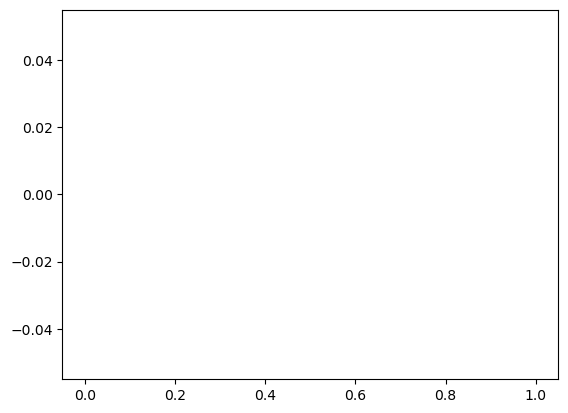

In [45]:
plt.hist(df_final[df_final['IoU'] == 0.75]['Precision'])

In [40]:
df_final[(df_final['IoU'].round(2) == 0.5) & (df_final['FN']>0)][['folder','file']]

,folder,file
0,train,MIT_232
0,train,MIT_236
0,train,MIT_252
0,train,MIT_288
0,train,MIT_289
...,...,...
0,test,VIT_730
0,test,VIT_770
0,test,VIT_771
0,test,VIT_843


In [71]:
df_final[(df_final['IoU'].round(2) == 0.75) & (df_final['Precision']<0.5)][['folder','file']]

,folder,file
5,train,MIT_107
5,train,MIT_127
5,train,MIT_393
5,train,MIT_449
5,train,MIT_450
...,...,...
5,test,TCE_1193
5,test,TCE_1266
5,test,TCE_1305
5,test,TCE_1347


### Confidence 0.5 and 0.4

In [42]:
df_test.groupby(['IoU', 'folder', 'conf']).mean(numeric_only=True)

AvgIOU         TP         FP         FN  Precision  \
IoU  folder conf                                                         
0.50 test   0.4   0.804425  19.472222   0.537037   0.145062   0.973951   
            0.5   0.794963  19.348889   0.493333   0.284444   0.975711   
     train  0.4   0.798375  19.475238   0.591429   0.178095   0.971162   
            0.5   0.798359  19.368571   0.459048   0.284762   0.977171   
0.55 test   0.4   0.799002  19.320988   0.688272   0.296296   0.966451   
            0.5   0.789313  19.188889   0.653333   0.444444   0.967556   
     train  0.4   0.793416  19.332381   0.734286   0.320952   0.963952   
            0.5   0.793323  19.225714   0.601905   0.427619   0.969829   
0.60 test   0.5   0.777875  18.851111   0.991111   0.782222   0.950178   
     train  0.5   0.783753  18.946667   0.880952   0.706667   0.955552   
     test   0.4   0.787879  18.996914   1.012346   0.620370   0.950093   
     train  0.4   0.783727  19.046667   1.020000   0.606667   0.949600   
0.65 test   0.5   0.759286  18.262222   1.580000   1.371111   0.919822   
     train  0.5   0.765310  18.379048   1.448571   1.274286   0.926571   
     test   0.4   0.770917  18.466049   1.543210   1.151235   0.922963   
     train  0.4   0.765031  18.467619   1.599048   1.185714   0.920314   
0.70 test   0.5   0.730622  17.286667   2.555556   2.346667   0.870000   
     train  0.5   0.735615  17.392381   2.435238   2.260952   0.876162   
     test   0.4   0.742038  17.500000   2.509259   2.117284   0.874105   
     train  0.4   0.735012  17.462857   2.603810   2.190476   0.869657   
0.75 test   0.5   0.682143  15.508889   4.333333   4.124444   0.779667   
     train  0.5   0.690089  15.728571   4.099048   3.924762   0.791295   
     test   0.4   0.696415  15.873457   4.135802   3.743827   0.792469   
     train  0.4   0.689273  15.779048   4.287619   3.874286   0.784924   
0.80 test   0.5   0.615949  12.771111   7.071111   6.862222   0.640911   
     train  0.5   0.622265  12.939048   6.888571   6.714286   0.649962   
     test   0.4   0.634172  13.373457   6.635802   6.243827   0.666389   
     train  0.4   0.621516  12.969524   7.097143   6.683810   0.644324   
0.85 test   0.5   0.527168   8.440000  11.402222  11.193333   0.422933   
     train  0.5   0.534523   8.730476  11.097143  10.922857   0.437695   
     test   0.4   0.541318   8.981481  11.027778  10.635802   0.446852   
     train  0.4   0.534057   8.742857  11.323810  10.910476   0.433581   
0.90 test   0.5   0.448015   3.515556  16.326667  16.117778   0.176133   
     train  0.5   0.450321   3.566667  16.260952  16.086667   0.178867   
     test   0.4   0.457493   3.925926  16.083333  15.691358   0.194938   
     train  0.4   0.450259   3.570476  16.496190  16.082857   0.177238   
0.95 test   0.5   0.408833   0.373333  19.468889  19.260000   0.018756   
     train  0.5   0.410226   0.380000  19.447619  19.273333   0.019124   
     test   0.4   0.413014   0.413580  19.595679  19.203704   0.020617   
     train  0.4   0.410318   0.380000  19.686667  19.273333   0.019019   

                    Recall        F1  
IoU  folder conf                      
0.50 test   0.4   0.992593  0.983086  
            0.5   0.985556  0.980222  
     train  0.4   0.990819  0.980819  
            0.5   0.985400  0.981095  
0.55 test   0.4   0.984753  0.975370  
            0.5   0.977178  0.971956  
     train  0.4   0.983343  0.973533  
            0.5   0.977914  0.973743  
0.60 test   0.5   0.959622  0.954600  
     train  0.5   0.963419  0.959429  
     test   0.4   0.968025  0.958827  
     train  0.4   0.968486  0.958924  
0.65 test   0.5   0.928933  0.924111  
     train  0.5   0.933971  0.930219  
     test   0.4   0.940123  0.931358  
     train  0.4   0.938457  0.929381  
0.70 test   0.5   0.878356  0.874000  
     train  0.5   0.883057  0.879467  
     test   0.4   0.890093  0.881914  
     train  0.4   0.886571  0.878105  
0.75 test   0.5   0.787000  0.783133  
     train  0.

### Between Pretrained and Fine Tuned model
- Pretrained: best_yolov8s.pt
- Fine tuned: best_custom.pt

In [487]:
df_final.groupby(['folder', 'IoU', 'model'])[['AvgIOU','TP','FP','FN','Precision','Recall','F1']].mean()

AvgIOU         TP         FP         FN  \
folder IoU  model                                                        
test   0.50 best_custom.pt   0.646400  15.475556   0.071111   4.157778   
            best_yolov8s.pt  0.794963  19.348889   0.493333   0.284444   
       0.55 best_custom.pt   0.644384  15.397778   0.148889   4.235556   
            best_yolov8s.pt  0.789313  19.188889   0.653333   0.444444   
       0.60 best_custom.pt   0.640452  15.237778   0.308889   4.395556   
            best_yolov8s.pt  0.777875  18.851111   0.991111   0.782222   
       0.65 best_custom.pt   0.630258  14.857778   0.688889   4.775556   
            best_yolov8s.pt  0.759286  18.262222   1.580000   1.371111   
       0.70 best_custom.pt   0.611438  14.111111   1.435556   5.522222   
            best_yolov8s.pt  0.730622  17.286667   2.555556   2.346667   
       0.75 best_custom.pt   0.573434  12.553333   2.993333   7.080000   
            best_yolov8s.pt  0.682143  15.508889   4.333333   4.124444   
       0.80 best_custom.pt   0.514751   9.957778   5.588889   9.675556   
            best_yolov8s.pt  0.615949  12.771111   7.071111   6.862222   
       0.85 best_custom.pt   0.451052   6.644444   8.902222  12.988889   
            best_yolov8s.pt  0.527168   8.440000  11.402222  11.193333   
       0.90 best_custom.pt   0.397335   3.146667  12.400000  16.486667   
            best_yolov8s.pt  0.448015   3.515556  16.326667  16.117778   
       0.95 best_custom.pt   0.366305   0.664444  14.882222  18.968889   
            best_yolov8s.pt  0.408833   0.373333  19.468889  19.260000   
train  0.50 best_custom.pt   0.655812  15.660000   0.067619   3.993333   
            best_yolov8n.pt  0.027350   0.296296   6.518519  19.629630   
            best_yolov8s.pt  0.798359  19.368571   0.459048   0.284762   
       0.55 best_custom.pt   0.654473  15.603810   0.123810   4.049524   
            best_yolov8n.pt  0.027350   0.296296   6.518519  19.629630   
            best_yolov8s.pt  0.793323  19.225714   0.601905   0.427619   
       0.60 best_custom.pt   0.650688  15.467619   0.260000   4.185714   
            best_yolov8n.pt  0.027231   0.259259   6.555556  19.666667   
            best_yolov8s.pt  0.783753  18.946667   0.880952   0.706667   
       0.65 best_custom.pt   0.641660  15.137143   0.590476   4.516190   
            best_yolov8n.pt  0.027042   0.185185   6.629630  19.740741   
            best_yolov8s.pt  0.765310  18.379048   1.448571   1.274286   
       0.70 best_custom.pt   0.623031  14.430476   1.297143   5.222857   
            best_yolov8n.pt  0.026882   0.111111   6.703704  19.814815   
            best_yolov8s.pt  0.735615  17.392381   2.435238   2.260952   
       0.75 best_custom.pt   0.585289  12.944762   2.782857   6.708571   
            best_yolov8n.pt  0.026594   0.000000   6.814815  19.925926   
            best_yolov8s.pt  0.690089  15.728571   4.099048   3.924762   
       0.80 best_custom.pt   0.523911  10.300952   5.426667   9.352381   
            best_yolov8n.pt  0.026594   0.000000   6.814815  19.925926   
            best_yolov8s.pt  0.622265  12.939048   6.888571   6.714286   
       0.85 best_custom.pt   0.455374   6.745714   8.981905  12.907619   
            best_yolov8n.pt  0.026594   0.000000   6.814815  19.925926   
            best_yolov8s.pt  0.534523   8.730476  11.097143  10.922857   
       0.90 best_custom.pt   0.402627   3.305714  12.421905  16.347619   
            best_yolov8n.pt  0.026594   0.000000   6.814815  19.925926   
            best_yolov8s.pt  0.450321   3.566667  16.260952  16.086667   
       0.95 best_custom.pt   0.370378   0.728571  14.999048  18.924762   
            best_yolov8n.pt  0.026594   0.000000   6.814815  19.925926   
            best_yolov8s.pt  0.410226   0.380000  19.447619  19.273333   

                             Precision    Recall        F1  
folder IoU  model                                           
test   0.50 best_custom.pt    0.994867  0.785622  0.870400  

# Generate Ground Truth images with bounding box

In [61]:

for folder_path in [train_path, test_path]:
    folder = folder_path.split("\\")[-1]
    image_path = folder_path + "/images"
    labels_path = folder_path + "/labels"
    out_folder = folder_path + "/label_images"
    text_folder = folder_path + "/gt_text"
    if not os.path.exists(out_folder):
        os.makedirs(out_folder)
    if not os.path.exists(text_folder):
        os.makedirs(text_folder)
    files = os.listdir(image_path)
    box_dict = {}
    # Inference on each image
    for file in files:
        file_path = image_path + "/" + file
        file_name = file.split(".")[0]
        label_path = labels_path + "/" + file_name + ".json"
        src_img = cv2.imread(file_path)
        img = src_img.copy()
        gt_bboxes = load_gt(label_path)
        for box in gt_bboxes:
            x1, y1, x2, y2 = box

            text_file = text_folder + "/" + str(box_cnt) + "_" + file
            cv2.imwrite(text_file, src_img[y1:y2, x1:x2])

        # Draw bounding box on image
            cv2.rectangle(img, (x1, y1), (x2, y2), (0, 0, 255), 2)

        out_file = out_folder + "/" + file
        cv2.imwrite(out_file, img)

JSONDecodeError: Invalid control character at: line 34 column 28 (char 648)

# Prepare Dataframe for YOLO

In [ ]:
cols = ['folder', 'src_img', 'gt_bbox', 'gt_nbox', 'gt_text', 'pred_bbox', 'pred_nbox', 'pred_text', 'text_img', 'iou']

# Match Ground Truth and Predicted Bounding box
- For every ground truth bounding box, find corresponding predicted bounding box 
- Predicted bounding box with max iou is mapped and minimum required iou is 0.5 

In [ ]:
def calc_iou(gt_box, pred_boxes):
    iou_list = []
    for pred_box in pred_boxes:
        xA = max(gt_box[0], pred_box[0])
        yA = max(gt_box[1], pred_box[1])
        xB = min(gt_box[2], pred_box[2])
        yB = min(gt_box[3], pred_box[3])

        # Compute intersection area
        interWidth = max(0, xB - xA + 1)
        interHeight = max(0, yB - yA + 1)
        interArea = interWidth * interHeight

        # Compute areas of each box
        boxAArea = (gt_box[2] - gt_box[0] + 1) * (gt_box[3] - gt_box[1] + 1)
        boxBArea = (pred_box[2] - pred_box[0] + 1) * (pred_box[3] - pred_box[1] + 1)

        # Compute IoU
        iou = interArea / float(boxAArea + boxBArea - interArea)
        iou_list.append(iou)
    max_index = np.argmax(iou_list)
    if iou_list[max_index] > 0.5:
        return int(max_index), iou_list[max_index]
    else:
        return int(-1), 0 

In [317]:
labels_path = r"F:\Muthu_2023\Personal\NextStep\Hackathon\DeHaDo_AI\tokenwise-dehado-ai\data\data2\train\labels"
df_gt = pd.DataFrame(columns = ['Field name','Field value','Coordinate','src_file','n_predbox','n_gtbox','pred_bbox_ind', 'iou', 'pred_bbox', 'pred_file'])
cnt = 0
for gt_file in os.listdir(labels_path):
    gt_file_path = labels_path + "/" + gt_file
    with open(gt_file_path, 'r') as f:
        data = json.load(f)
    df_temp = pd.DataFrame(data)
    file_name = gt_file.split(".")[0]

    df_temp['src_file'] = file_name
    pred_bboxes = np.round(box_dict[file_name])
    df_temp['n_predbox'] = len(pred_bboxes)
    df_temp['n_gtbox'] = len(df_temp)
    df_temp[['pred_bbox_ind', 'iou']] = df_temp['Coordinate'].apply(lambda x: pd.Series(calc_iou(x, pred_bboxes)))
    df_temp['pred_bbox'] = df_temp['pred_bbox_ind'].apply(lambda x: pred_bboxes[int(x)].tolist() if x>=0  else [])
    df_temp['pred_file'] = df_temp['pred_bbox_ind'].apply(lambda x:  str(int(x)+1) + "_" + file_name if x>=0 else "")
        
    df_gt = pd.concat([df_gt, df_temp])
    cnt += 1    

In [320]:
df_gt.to_csv("df_master.csv", index=False)

In [297]:
df_gt['iou'].mean()

0.8466296521967533

# Performance Analysis

In [322]:
metric_dict = {}
df_map = pd.DataFrame()
for threshold in np.arange(0.5, 1, 0.05):
    print("Map for " + str(threshold) + " started...")
    for key, val in gt_dict.items():
        metric_dict[key] = evaluate_map_05(box_dict[key], gt_dict[key], threshold)
        df_map[threshold] = pd.DataFrame.from_dict(metric_dict, orient='index').mean()

Map for 0.5 started...
Map for 0.5 started...
Map for 0.5 started...
Map for 0.5 started...
Map for 0.5 started...
Map for 0.5 started...
Map for 0.5 started...
Map for 0.5 started...
Map for 0.5 started...
Map for 0.5 started...


<Axes: >

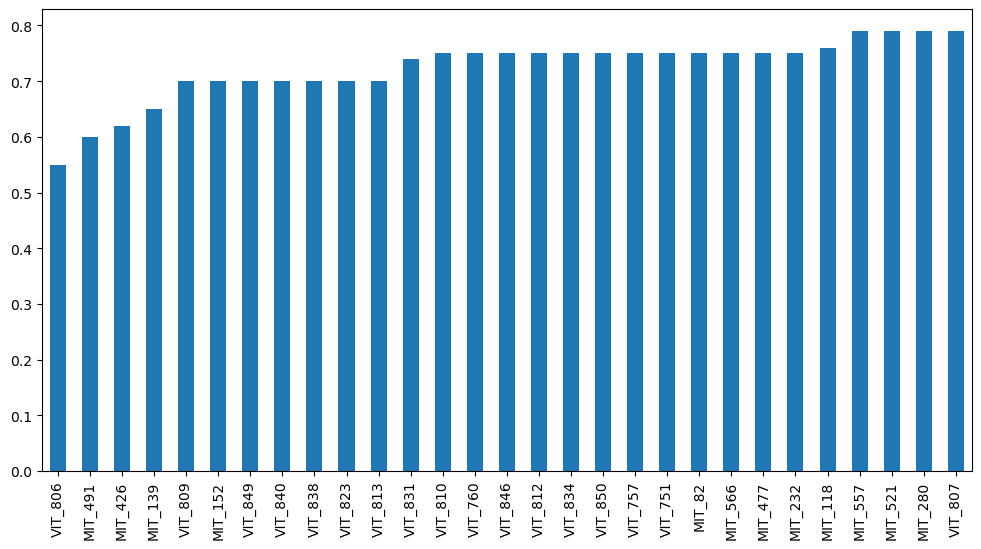

In [307]:
plt.figure(figsize=(12,6))
metric75[metric75['Recall'] < 0.8].sort_values(by='Recall')['Recall'].plot(kind='bar')

In [311]:
# At Confidence = 0.5
df_gt = pd.read_csv(r"F:\Muthu_2023\Personal\NextStep\Hackathon\DeHaDo_AI\Results\Run1\df_master.csv")
gt_dict = df_gt.groupby("src_file")['Coordinate'].apply(list).to_dict()
with open(r"F:\Muthu_2023\Personal\NextStep\Hackathon\DeHaDo_AI\Results\Run1\bbox_dict.pickle", 'rb') as f:
    box_dict = pickle.load(f)

# Fine Tune Yolo on Custom Dataset

In [344]:
# Prepare Labels
def convert_to_yolo(coord, img_width, img_height):
    # center
    [x1, y1, x2, y2] = coord
    x_center = (x1 + x2) / 2.0
    y_center = (y1 + y2) / 2.0
    # width and height
    width = x2 - x1
    height = y2 - y1
    # normalize
    x_center /= img_width
    y_center /= img_height
    width /= img_width
    height /= img_height
    return np.round([x_center, y_center, width, height],2)

In [371]:
train_path = r"F:\Muthu_2023\Personal\NextStep\Hackathon\DeHaDo_AI\Dataset\train"
test_path = r"F:\Muthu_2023\Personal\NextStep\Hackathon\DeHaDo_AI\Dataset\test"

for path in [train_path, test_path]:
    label_path = path + "/" + "labels"
    output_path = path + "/" + "labels_yolo"
    if path == train_path:
        continue
    if not os.path.exists(output_path):
        os.makedirs(output_path)
    cnt = 0
    for file in os.listdir(label_path):
        cnt +=1
        if cnt < 300:
            continue
        file_name = file.split(".")[0]
        img = cv2.imread(path + "/" + "images/" + file_name + ".jpg")
        h = img.shape[0]
        w = img.shape[1]
        with open(label_path + "/" + file, 'r') as f:
            data = json.load(f)
            
        coordinates = [d['Coordinate'] for d in data]
        with open(output_path + "/" + file_name + ".txt", "w") as f:  
            for coord in coordinates:              
                line = "0 " + " ".join(map(str, list(convert_to_yolo(coord, w, h)))) + "\n"
                f.write(line)

In [370]:
with open(label_path + "/" + file, 'r') as f:
    data = json.load(f)

## Split Training set into Train(90%) and validation set (10%)

In [373]:
import shutil

In [374]:
import os
from sklearn.model_selection import train_test_split

image_dir = r"F:\Muthu_2023\Personal\NextStep\Hackathon\DeHaDo_AI\Dataset_Yolo\train\images"
label_dir = r"F:\Muthu_2023\Personal\NextStep\Hackathon\DeHaDo_AI\Dataset_Yolo\train\labels"

images = sorted(os.listdir(image_dir))
train_imgs, val_imgs = train_test_split(images, test_size=0.1, random_state=42)



In [375]:
# Create new structure under /kaggle/working/
os.makedirs("data/train/images", exist_ok=True)
os.makedirs("data/val/images", exist_ok=True)
os.makedirs("data/train/labels", exist_ok=True)
os.makedirs("data/val/labels", exist_ok=True)

for img in train_imgs:
    shutil.copy(os.path.join(image_dir, img), f"data/train/images/{img}")
    shutil.copy(os.path.join(label_dir, img.replace('.jpg', '.txt')), f"data/train/labels/{img.replace('.jpg', '.txt')}")

for img in val_imgs:
    shutil.copy(os.path.join(image_dir, img), f"data/val/images/{img}")
    shutil.copy(os.path.join(label_dir, img.replace('.jpg', '.txt')), f"data/val/labels/{img.replace('.jpg', '.txt')}")

# LayoutLM Model

In [ ]:
from transformers import LayoutLMv3ForTokenClassification, LayoutLMv3Processor
from PIL import Image

In [ ]:
model = LayoutLMv3ForTokenClassification.from_pretrained("microsoft/layoutlmv3-base")
processor = LayoutLMv3Processor.from_pretrained("microsoft/layoutlmv3-base")

In [ ]:
from transformers import AutoModel
model = AutoModel.from_pretrained("microsoft/layoutlmv3-base")